#### calculate concordance, by quantile

In [68]:
import pandas as pd
import pickle
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [109]:
def getConcordance(df, vleft, vright):
    df['concordance'] = np.nan
    if(len(df) < 1):
        return df
    
    df['concordance'] = 0
    df.loc[(df.y_pred > vleft) & (df.y_pred <= vright),'concordance'] = 1
    return df

In [168]:
df_conc = pd.DataFrame()
for fname in glob.glob('../out/20.0518 L100/L100_reg_rf_boruta/model_perf/y_compr_*.pkl'):
    f = re.sub('.*_compr_','',fname)
    gene = re.sub('\.pkl','',f)
    df = pickle.load(open(fname, 'rb'))
    df = df['te']
    
    df['y_actual_cat'] = pd.cut(df.y_actual, [-10, -1, -0.5, -0.05, 10])
    #df['y_actual_cat'] = pd.cut(df.y_actual, [-10, -0.5, 10])
    df_conc_s = pd.DataFrame()
    for cat,df_cat in df.groupby('y_actual_cat'):
        df_cat = getConcordance(df_cat.copy(), cat.left, cat.right)
        n = df_cat.shape[0]
        if n < 1: continue
        
        p = sum(df_cat.concordance==1) / df_cat.shape[0]
        ci95 = 1.96*np.sqrt(p*(1-p)/n)
        dfc = pd.DataFrame([{'y_actual_cat': cat, 
                             'concordance': p,
                             'ci95': [np.round(p-ci95,2), np.round(p+ci95,2)],
                             'n': n}])
        df_conc_s = pd.concat([df_conc_s,dfc])
    df_conc_s['gene'] = gene    
    df_conc_s = df_conc_s[['gene','y_actual_cat','concordance','ci95','n']]
    
    df_conc = pd.concat([df_conc,df_conc_s])


In [169]:
df_conc.head()

,gene,y_actual_cat,concordance,ci95,n
0,EEF2,"(-10.0, -1.0]",1.000000,"[1.0, 1.0]",87
0,ELMO2,"(-10.0, -1.0]",0.000000,"[0.0, 0.0]",7
0,ELMO2,"(-1.0, -0.5]",0.714286,"[0.52, 0.91]",21
0,ELMO2,"(-0.5, -0.05]",0.792453,"[0.68, 0.9]",53
0,ELMO2,"(-0.05, 10.0]",0.000000,"[0.0, 0.0]",6


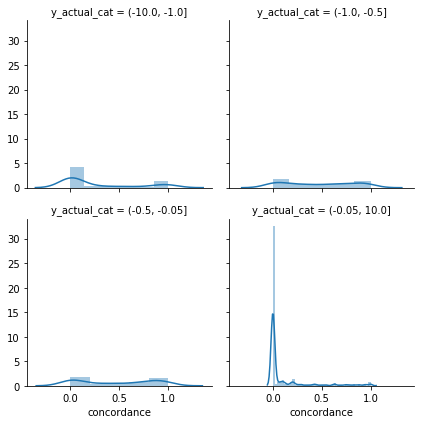

In [170]:
g = sns.FacetGrid(df_conc, col="y_actual_cat", margin_titles=True, col_wrap=2)
g.map(sns.distplot, 'concordance')